## Relatório do TP 1 de algorítimos 2 ##

#### Autores: Lorenzo Carneiro Magalhães e Tomás Lacerda Muniz

imports 

In [40]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris, load_wine, load_digits, load_breast_cancer
from utils import *
from graham_scan import graham_scan
from sweep_line_intersection import sweep_line_intersection
from dataset import get_dataset
from linear_separation import linear_separation
from linear_classification import linear_classification
from svm import classify_points_svm
from pca import apply_pca

função para carregar um dataset

In [41]:
def load_dataset(input_data):
    # Check if the input is a string (filename)
    if isinstance(input_data, str):
        with open(input_data, 'r') as file:
            data = file.read()
            return data
    
    # Check if the input is a function
    elif callable(input_data):
        return input_data()

Inicializamos todos os valores de cada variável com 0, essas variáveis serão usadas para rastrear o tempo de execução do nosso algorítimo

In [42]:
time_hull = time_intersection = time_linear_sep = time_linear_class = 0

Inicializamos também os datasets em um dicionário para facilitar o acesso dos outros 9 datasets que usaremos tirando o iris

In [43]:
datasets = {
        "wine": load_wine,
        "digits": load_digits,
        "breast_cancer": load_breast_cancer
    }

### Explicando o algorítimo através do banco de dados da Iris

Acompanhemos os testes na base de dados iris

In [44]:
iris = load_iris

In [45]:
# Carregando a base de dados em pandas
data = load_dataset(iris)
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target

Após carregar o banco de dados iris, vamos verificar se estes possuem mais do que 2 classes, e caso possua realizaremos um PCA para reduzir a dimensionalidade da matriz

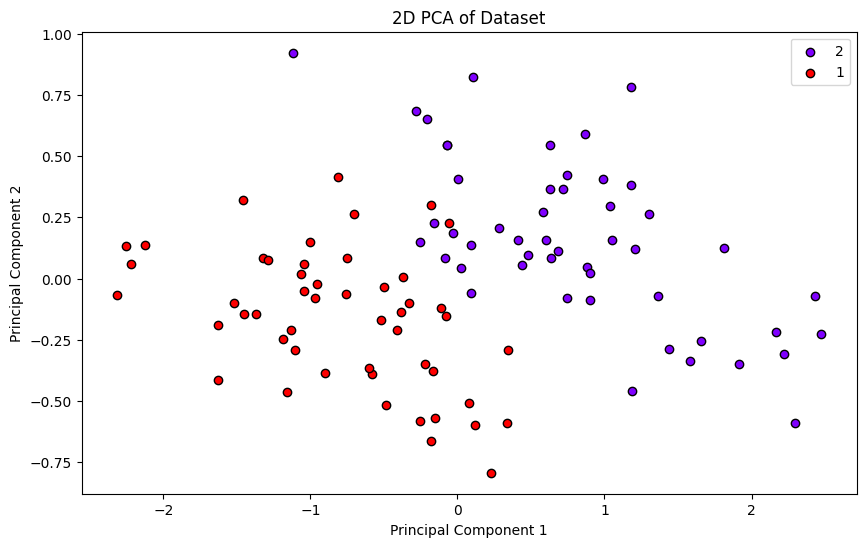

In [46]:
unique_classes = np.unique(df['target'])

if unique_classes.size > 2:
    # randomly select 2 classes
    selected_classes = np.random.choice(unique_classes, 2, replace=False)

    filtered_df = df[df['target'].isin(selected_classes)]

if df.shape[1] > 3: # 3 because of target
    # Extract data and labels from the filtered dataframe
    X_filtered = filtered_df.drop('target', axis=1).values
    y_filtered = filtered_df['target'].values

    # Apply PCA and visualize the result
    reduced_data = apply_pca(X_filtered, y_filtered, target_names=selected_classes, visualize = True)


Note que agora pegamos um dataset como o da iris e reduzimos a dimensionalidade dele para 2, isso é importante para que possamos visualizar os dados em um gráfico e por consequência traçar a envoltória

In [47]:
reduced_df = pd.DataFrame(reduced_data, columns=['x', 'y'])
reduced_df['target'] = y_filtered

reduced_df = reduced_df.sample(frac=0.2).reset_index(drop=True)

X1 = reduced_df[reduced_df['target'] == selected_classes[0]][['x', 'y']]
X2 = reduced_df[reduced_df['target'] == selected_classes[1]][['x', 'y']]

# making the hull for each
hull1, time1_ = graham_scan([Point(row['x'], row['y']) for _, row in X1.iterrows()])
hull2, time2_ = graham_scan([Point(row['x'], row['y']) for _, row in X2.iterrows()])


Segue a explicação do nosso algorítimo de graham scan para encontrar a envoltória convexa

##### Função graham_scan

Aqui foi usado o algorítimo de graham scan para encontrar a envoltória convexa, a função recebe uma lista de pontos e retorna a lista de pontos que forma a envoltória convexa.

A função faz isso da seguinte forma:

Inicialmente testamos para ver se a lista possue pelomenos 3 pontos, caso não possua é impossível fazer uma envoltória.

Então encontramos o ponto âncora, que é o ponto com a menor coordenada Y. Se houver empates o com a menor coordenada em X é escolinho.

Organizamos os pontos baseados em seu ângulo polar com o ponto âncora.

Criamos uma pilha para armazenar os pontos da envoltória, e colocamos os 3 primeiros pontos da lista nela.

O loop while interno remove pontos da pilha que não formam uma curva à esquerda (ou seja, não fazem parte do invólucro convexo) quando considerados junto com o ponto atual em análise.

E então retornamos a pilha.

In [48]:
# Armazenando tempo
time_hull += time1_
time_hull += time2_

In [49]:
hull1_segments = hull_to_segments(hull1)
hull2_segments = hull_to_segments(hull2)

##### Função hull_to_segments

A função hull_to_segments percorre os pontos de uma lista de pontos e cria uma lista de segmentos através de um loop.

Usando a função (hull[(i+1) % len(hull)]) garantimos que o ciclo se fecha.

Retorna a lista de segmentos

In [50]:
intersection, time_ = sweep_line_intersection(hull1_segments, hull2_segments)
time_intersection += time_

if intersection:
    print("Intersects\n")
else:
    print("Not intersects")

Not intersects


##### Função sweep_line_intersection

O código define a função sweep_line_intersection que verifica se há interseções entre duas listas de segmentos, segments1 e segments2.

Para fazer isso, a função utiliza o algoritmo de varredura linear.

Primeiramente, pontos de início e fim de cada segmento são adicionados a uma lista de eventos, que é então organizada em uma heap com base nas coordenadas x. 

A função então verifica, ponto por ponto, se há interseções entre os segmentos ativos de segments1 e segments2. 

Se uma interseção for encontrada, a função retorna True, caso contrário, ela continua até que todos os eventos sejam processados e, finalmente, retorna False se nenhuma interseção for encontrada

In [51]:
(a, b, c, mx, my), time_ = linear_separation(hull1, hull2)

time_linear_sep += time_

X = reduced_df[['x', 'y']].values
y = reduced_df['target'].values


##### Função linear_separation

A função linear_separation determina uma linha reta que separa os pontos de dois fechos convexos (hull1 e hull2).

Ela começa encontrando os pontos mais próximos entre os dois fechos usando a função find_closest_points. 

Depois, determina o ponto médio entre esses dois pontos. 

O objetivo é encontrar uma linha perpendicular à linha formada pelos dois pontos mais próximos. 

Se a linha entre p1 e p2 não for vertical, o coeficiente angular da linha perpendicular é calculado como o negativo do inverso do coeficiente angular de p1 e p2. 

Se for vertical, o coeficiente angular da linha perpendicular é definido como zero. 

Finalmente, a equação da linha é formulada no formato ax + by + c = 0, usando o coeficiente angular da linha perpendicular e o ponto médio. 

A função retorna os coeficientes a, b, e c dessa equação, juntamente com as coordenadas x e y do ponto médio.

In [52]:
acc_svm, precision_svm, recall_svm, f1_svm, abc_svm = classify_points_svm(X, y, plot_boundary=False)

##### Função classify_points_svm

A função classify_points_svm usa uma SVM com um kernel linear para classificar pontos. 

Ela divide os pontos de entrada em conjuntos de treinamento e de teste. 

Depois, treina a SVM no conjunto treinamento e faz as previsões no conjunto teste. 

As métricas de acurácia, precisão, recall e pontuação F1 são calculadas com base nas previsões. 

Se o parâmetro plot_boundary for verdadeiro, a função plota os pontos e a fronteira de decisão da SVM. 

Finalmente, a função retorna as métricas calculadas e os coeficientes da linha que representa a fronteira de decisão.

In [53]:
(acc, precision, recall, f1), time_ = linear_classification(X, y, a, c, selected_classes[0], selected_classes[1])

##### Função linear_classification

A função linear_classification separa as duas classes com uma linha reta. 

Ela verifica se cada ponto está acima ou abaixo da linha e faz uma previsão da classe com base no posicionamento relativo a linha. 

Após classificar todos os pontos, a função avalia a precisão dessas previsões comparando-as com os rótulos verdadeiros, usando as métricas de acurácia, precisão, recall e pontuação F1. 

Ela retorna as métricas de avaliação e os coeficientes da linha reta.


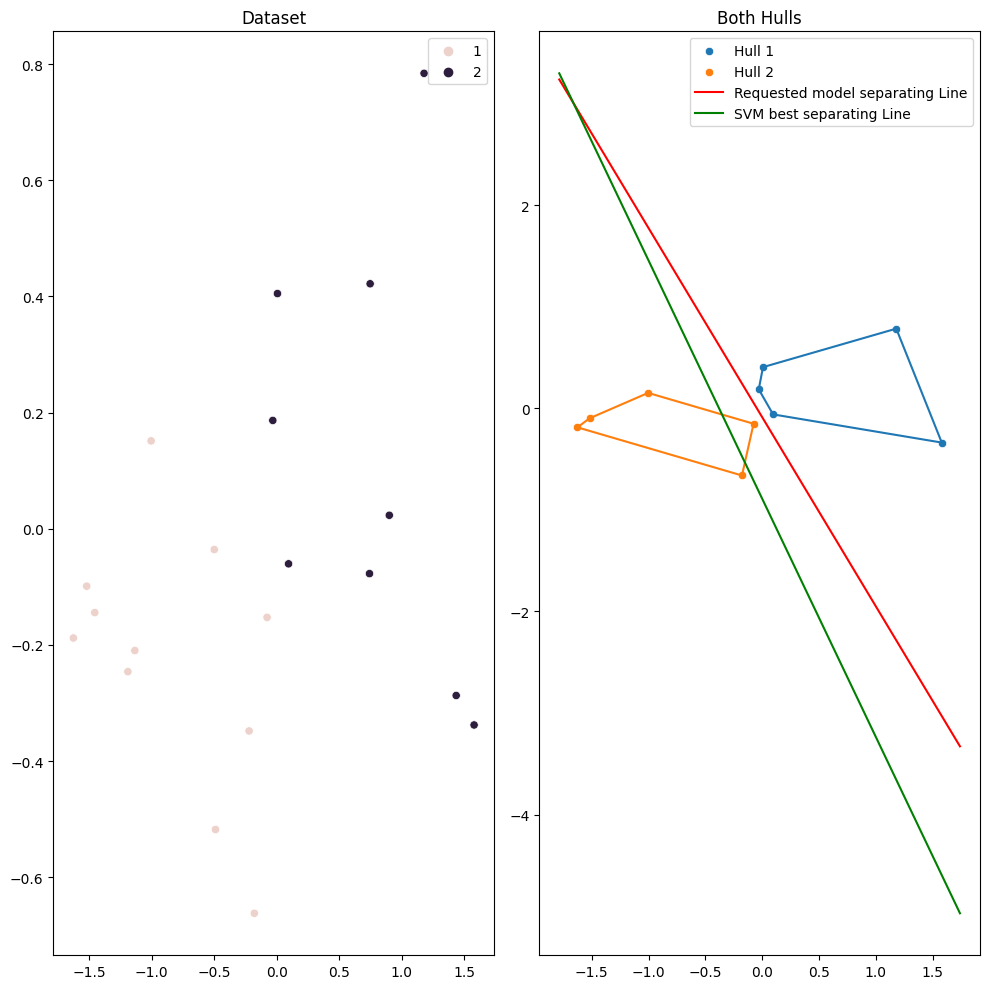

In [54]:
# Plotting the data
if not intersection:
    plot_grid_hulls_separation(X, y, hull1, hull2, intersection, (a,b,c), abc_svm, save=True, filename=f"graphs/dataset_iris.png")

print()

#### Metricas de avaliação

In [55]:
time_linear_class += time_
print(f"METRICS: Accuracy: {acc}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}")
print(f"METRICS SVM: Accuracy: {acc_svm}, Precision: {precision_svm}, Recall: {recall_svm}, F1 Score: {f1_svm}")
print(f"Time hull: {time_hull}")
print(f"Time intersection: {time_intersection}")
print(f"Time linear separation: {time_linear_sep}")
print(f"Time linear classification: {time_linear_class}")

METRICS: Accuracy: 0.55, Precision: 0.0, Recall: 0, F1 Score: 0
METRICS SVM: Accuracy: 0.8333333333333334, Precision: 0.8333333333333333, Recall: 0.875, F1 Score: 0.8285714285714285
Time hull: 7.345799531321973e-05
Time intersection: 7.045800157357007e-05
Time linear separation: 4.345799970906228e-05
Time linear classification: 5.654199776472524e-05


##### Explicar métricas aqui

### Outros 9 Datasets 

Dataset: wine
Not intersects
METRICS: Accuracy: 0.3076923076923077, Precision: 0.0, Recall: 0, F1 Score: 0
METRICS SVM: Accuracy: 0.875, Precision: 0.75, Recall: 0.9285714285714286, F1 Score: 0.7948717948717948

Dataset: digits
Not intersects
METRICS: Accuracy: 0.5205479452054794, Precision: 0.0, Recall: 0, F1 Score: 0
METRICS SVM: Accuracy: 0.9545454545454546, Precision: 0.9642857142857143, Recall: 0.9444444444444444, F1 Score: 0.9520697167755992

Dataset: breast_cancer
Not intersects
METRICS: Accuracy: 0.5616438356164384, Precision: 0.0, Recall: 0, F1 Score: 0
METRICS SVM: Accuracy: 1.0, Precision: 1.0, Recall: 1.0, F1 Score: 1.0

Time hull: 0.0005418739892775193
Time intersection: 0.0004341239982750267
Time linear separation: 0.00016641700494801626
Time linear classification: 0.0003195000026607886


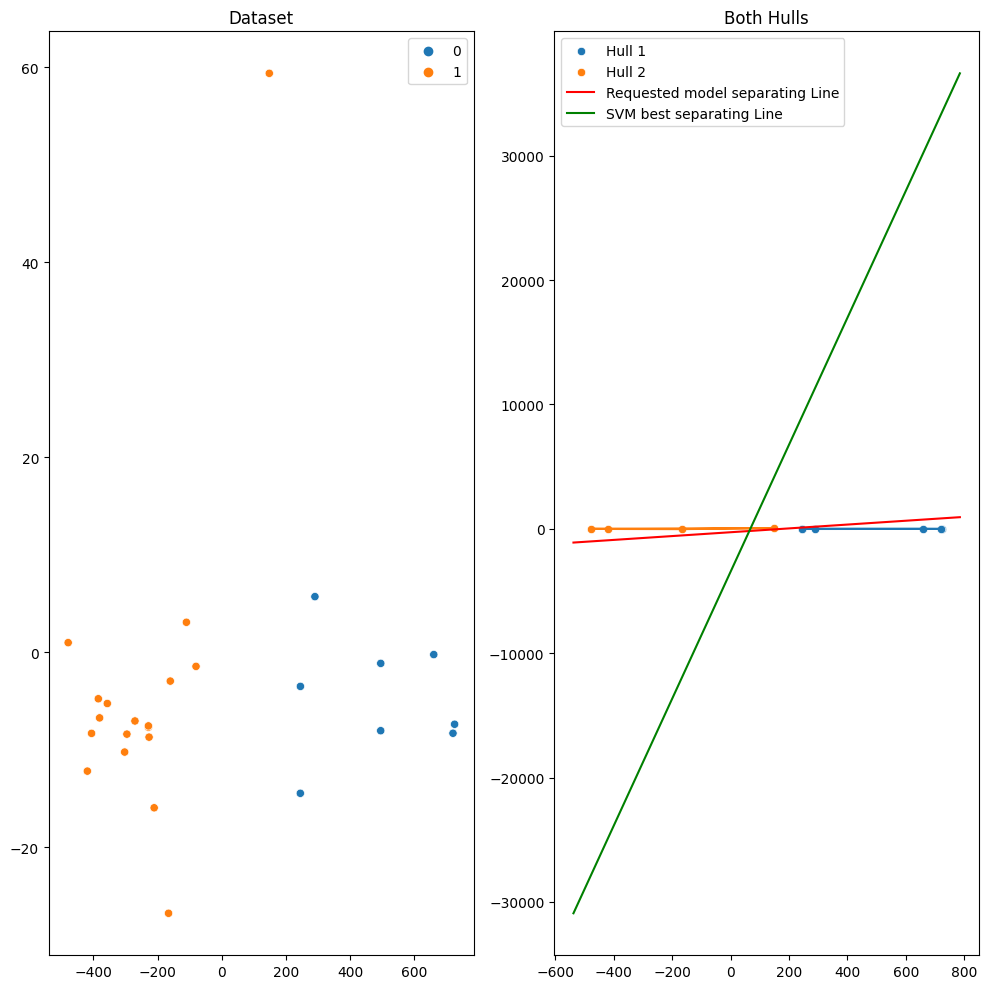

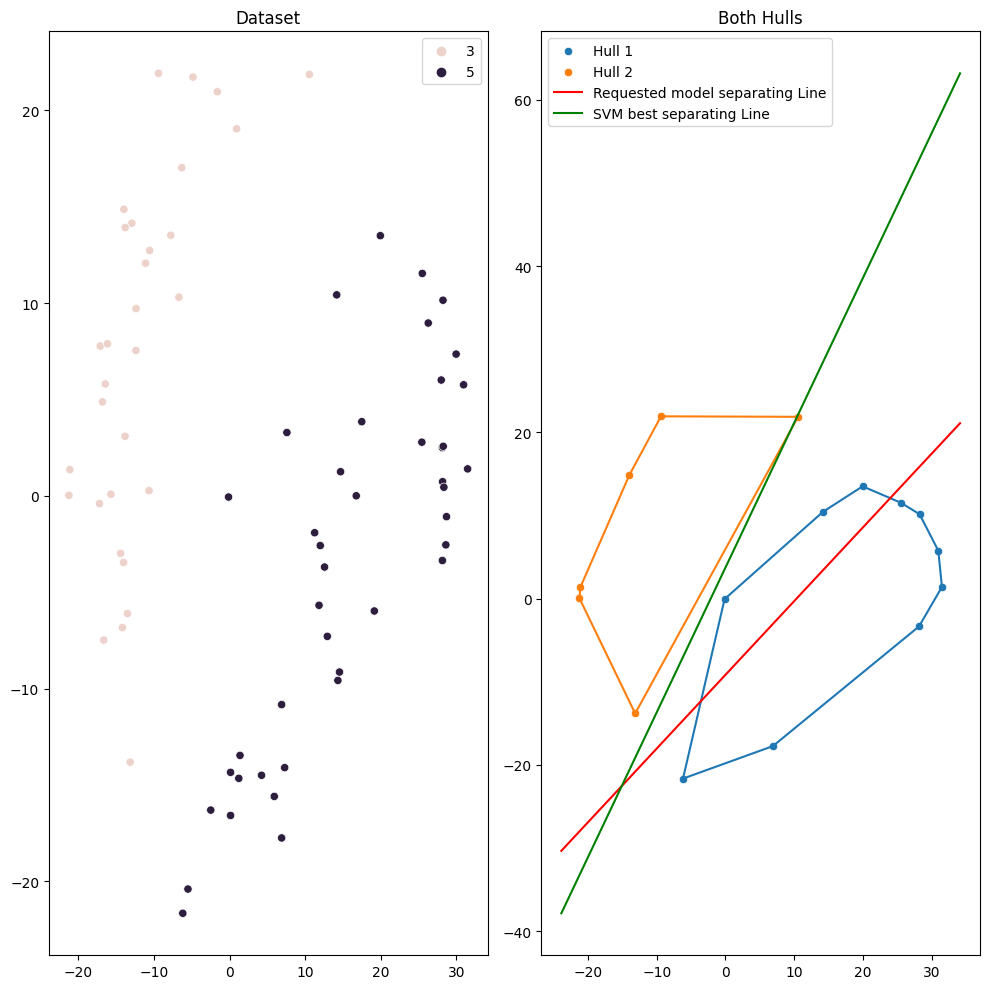

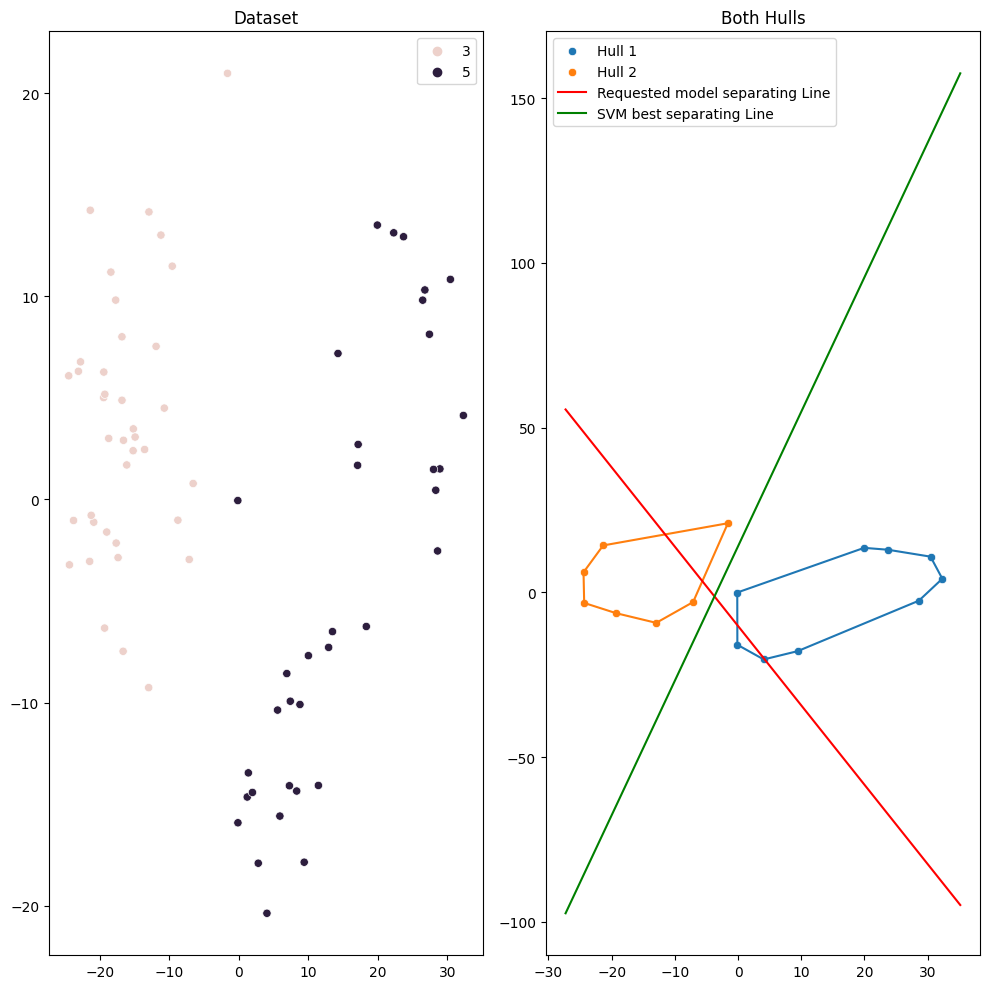

In [56]:
for d_name, d in datasets.items():

    print(f"Dataset: {d_name}")

    data = load_dataset(d)

    df = pd.DataFrame(data.data, columns=data.feature_names)
    df['target'] = data.target

    # verify if it is a binary classification problem
    unique_classes = np.unique(df['target'])
    if unique_classes.size > 2:
        # randomly select 2 classes
        selected_classes = np.random.choice(unique_classes, 2, replace=False)

        filtered_df = df[df['target'].isin(selected_classes)]

    if df.shape[1] > 3: # 3 because of target
        # Extract data and labels from the filtered dataframe
        X_filtered = filtered_df.drop('target', axis=1).values
        y_filtered = filtered_df['target'].values

        # Apply PCA and visualize the result
        reduced_data = apply_pca(X_filtered, y_filtered, target_names=selected_classes)

    reduced_df = pd.DataFrame(reduced_data, columns=['x', 'y'])
    reduced_df['target'] = y_filtered

    reduced_df = reduced_df.sample(frac=0.2).reset_index(drop=True)

    X1 = reduced_df[reduced_df['target'] == selected_classes[0]][['x', 'y']]
    X2 = reduced_df[reduced_df['target'] == selected_classes[1]][['x', 'y']]

    # making the hull for each
    hull1, time1_ = graham_scan([Point(row['x'], row['y']) for _, row in X1.iterrows()])
    hull2, time2_ = graham_scan([Point(row['x'], row['y']) for _, row in X2.iterrows()])

    time_hull += time1_
    time_hull += time2_

    # making the segments for each hull
    hull1_segments = hull_to_segments(hull1)
    hull2_segments = hull_to_segments(hull2)

    # make the sweep line intersection
    intersection, time_ = sweep_line_intersection(hull1_segments, hull2_segments)

    time_intersection += time_

    if intersection:
        print("Intersects\n")
        continue
    else:
        print("Not intersects")

    # ax + by + c = 0
    (a, b, c, mx, my), time_ = linear_separation(hull1, hull2)

    time_linear_sep += time_
    
    X = reduced_df[['x', 'y']].values
    y = reduced_df['target'].values

    acc_svm, precision_svm, recall_svm, f1_svm, abc_svm = classify_points_svm(X, y, plot_boundary=False)

    (acc, precision, recall, f1), time_ = linear_classification(X, y, a, c, selected_classes[0], selected_classes[1])


    time_linear_class += time_

    print(f"METRICS: Accuracy: {acc}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}")

    print(f"METRICS SVM: Accuracy: {acc_svm}, Precision: {precision_svm}, Recall: {recall_svm}, F1 Score: {f1_svm}")

    # Plotting the data
    if not intersection:
        plot_grid_hulls_separation(X, y, hull1, hull2, intersection, (a,b,c), abc_svm, save=True, filename=f"graphs/dataset_{d_name}.png")

    print()
    
print(f"Time hull: {time_hull}")
print(f"Time intersection: {time_intersection}")
print(f"Time linear separation: {time_linear_sep}")
print(f"Time linear classification: {time_linear_class}")